# Load Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from utils.dataset import LoadImagesAndLabels, load_img, letterbox
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
import multiprocessing
import pytorch_lightning as pl

In [3]:
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
normalize = Normalize(mean=mean, std=std)
unormalize = Normalize(mean=-mean/std, std=1/std)
data = LoadImagesAndLabels(path = '../data', transforms=normalize, img_size = 224)

# Show some images with the mask

torch.Size([3, 224, 224]) torch.Size([50176])


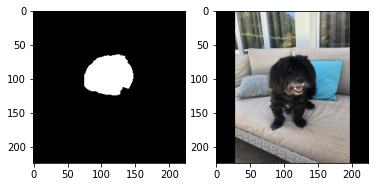

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) torch.Size([50176])


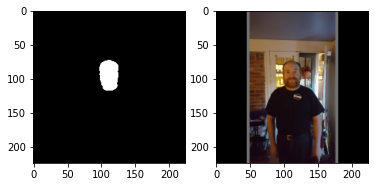

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) torch.Size([50176])


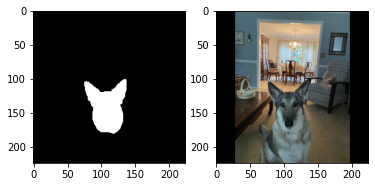

torch.Size([3, 224, 224]) torch.Size([50176])


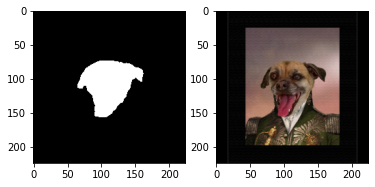

torch.Size([3, 224, 224]) torch.Size([50176])


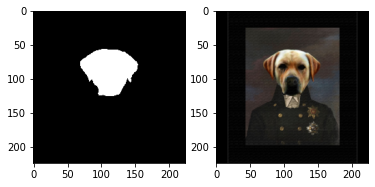

torch.Size([3, 224, 224]) torch.Size([50176])


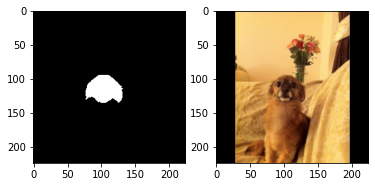

torch.Size([3, 224, 224]) torch.Size([50176])


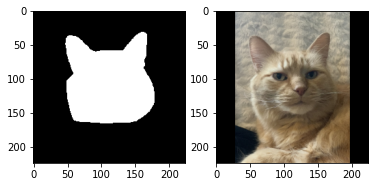

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) torch.Size([50176])


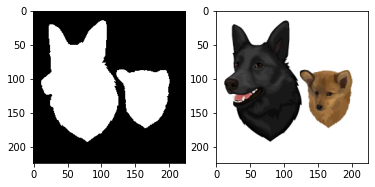

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) torch.Size([50176])


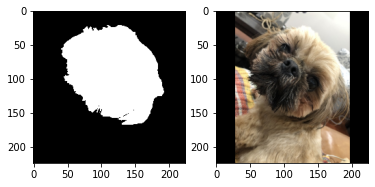

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) torch.Size([50176])


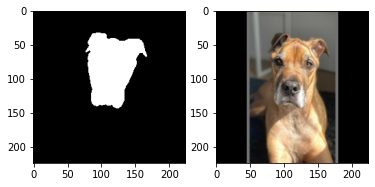

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) torch.Size([50176])


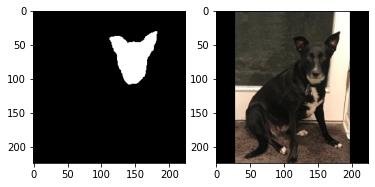

torch.Size([3, 224, 224]) torch.Size([50176])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


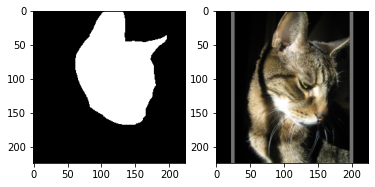

In [8]:
count = 0
for img, mask in data:
    print(img.shape, mask.shape)
    plt.subplot(1,2,1)
    plt.imshow(mask.view(data.img_size, data.img_size), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(np.transpose(unormalize(img), (1,2,0)))
    plt.show()
    if count > 10:
        break
    count += 1

# Pretrained weights for transfer learning

In [3]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=True)
model.eval()

Using cache found in /home/lasker/.cache/torch/hub/pytorch_vision_v0.6.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Create data loaders

In [12]:
from tqdm.notebook import tqdm
class SSModel(pl.LightningModule):
    def __init__(self, out_features):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.regression_pixe = nn.Sequential(
            nn.Linear(3136, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(4096, out_features, bias=True),
        )
        
    def forward(self, x):
        bs, c, h, w = x.shape
        x = self.decoder(x)
        x = self.avgpool(x).view(bs, -1)
        x = self.regression_pixe(x)
        return x

In [26]:
model = SSModel(data.img_size*data.img_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

pbar = tqdm(range(100), position=0, total=100)
x, y = data[0]

for i in pbar:
    optimizer.zero_grad()
    y_predict = model(x.unsqueeze(0))
    loss = criterion(y.unsqueeze(0), y_predict)
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=loss.item())

Exception ignored in: <function tqdm.__del__ at 0x7fbd63f927a0>
Traceback (most recent call last):
  File "/home/lasker/Desktop/aiPet/.env/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/home/lasker/Desktop/aiPet/.env/lib/python3.7/site-packages/tqdm/notebook.py", line 270, in close
    if self.total and self.n < self.total:
AttributeError: 'tqdm_notebook' object has no attribute 'total'


In [28]:
with torch.no_grad():
    y_predict = model(x.unsqueeze(0))

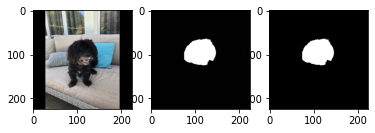

In [33]:
plt.subplot(1,3,1)
plt.imshow(np.transpose(unormalize(x), (1,2,0)))
plt.subplot(1,3,2)
plt.imshow(y_predict.view(224, 224), cmap="gray")
plt.subplot(1,3,3)
plt.imshow(y.view(224, 224), cmap="gray")
plt.show()

# Pytorch lighting

In [5]:
train_dataloader = DataLoader(data, batch_size=4, shuffle=True, num_workers=multiprocessing.cpu_count())

In [6]:
out_features = data.img_size*data.img_size

In [6]:
class LitAutoEncoder (pl.LightningModule):
    def __init__(self, out_features):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.classifier = nn.Sequential(
            nn.Linear(3136, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(4096, out_features, bias=True)
        )
        self.loss = nn.BCEWithLogitsLoss()
        
    def forward(self, x):
        bs, c, h, w = x.shape
        x = self.decoder(x)
        x = self.avgpool(x).view(bs, -1)
        x = self.classifier(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = self(x)
        loss = self.loss(x, y)
        self.log('train_loss', loss)
        return loss

In [8]:
model_train = LitAutoEncoder(out_features)

In [9]:
trainer = pl.Trainer(gpus=0, num_nodes=1)
trainer.fit(model_train, train_dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/lasker/Desktop/aiPet/.env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name       | Type              | Params
-------------------------------------------------
0 | decoder    | Sequential        | 1.8 K 
1 | avgpool    | AdaptiveAvgPool2d | 0     
2 | classifier | Sequential        | 218 M 
3 | loss       | BCEWithLogitsLoss | 0     
-------------------------------------------------
218 M     Trainable params
0         Non-trainable params
218 M     Total params


/home/lasker/Desktop/aiPet/.env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [31]:
# x, y = data[2]
# with torch.no_grad():
#     y_pred = model_train(x.unsqueeze(0))
# plt.subplot(1,3,1)
# plt.imshow(np.transpose(unormalize(x), (1,2,0)))
# plt.subplot(1,3,2)
# plt.imshow(y_pred.to(dtype=torch.uint8).view(224, 224), cmap="gray")
# plt.subplot(1,3,3)
# plt.imshow(y.view(224, 224), cmap="gray")
# plt.show()

In [52]:
torch.save(model_train, "test.pth")

# Test Model

In [7]:
model = torch.load("test.pth")

In [25]:
model

LitAutoEncoder(
  (decoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=50176, bias=True)
  )
  (loss): BCEWithLogitsLoss()
)

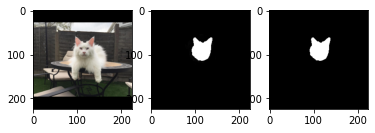

In [30]:
x, y = data[80] # Test overfitting to know if the architecture is good
with torch.no_grad():
    y_pred = model(x.unsqueeze(0)).sigmoid()
plt.subplot(1,3,1)
plt.imshow(np.transpose(unormalize(x), (1,2,0)))
plt.subplot(1,3,2)
plt.imshow(y_pred.view(224, 224), cmap="gray")
plt.subplot(1,3,3)
plt.imshow(y.view(224, 224), cmap="gray")
plt.show()

In [18]:
img = load_img("../source/test_new.png", 224)

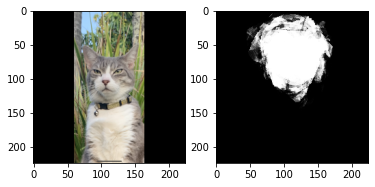

In [19]:
with torch.no_grad():
    y_pred = model(normalize(img).unsqueeze(0)).sigmoid()
plt.subplot(1,2,1)
plt.imshow(np.transpose(img, (1,2,0)))
plt.subplot(1,2,2)
plt.imshow(y_pred.view(224, 224), cmap="gray")
plt.show()